# Homework 1

In [1]:
# Loading libraries
import pandas
from pandas.plotting import scatter_matrix
import numpy as np
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc, roc_auc_score,average_precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
#from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.svm import LinearSVC

In [2]:
#Loading Data Set

bofTrain = pandas.read_csv("NBC_bag_of_words_5.csv",header = None) 
labelsTrain = pandas.read_csv("NBC_classes_5.txt",header = None)

bofTest = pandas.read_csv("test_bag_of_words_5.csv",header = None)
labelsTest = pandas.read_csv("test_classes_5.txt",header = None)  

vocab =  pandas.read_csv("NBC_vocab_5.txt",header = None)
vocabArray = vocab.values

#converting into matrices with the correct values
X = bofTrain.values #train data
Y = labelsTrain.values #train target

Xtest = bofTest.values #test data
Ytest = labelsTest.values #test target


Text(0, 0.5, "Times word 'y' was mentioned in Review x")

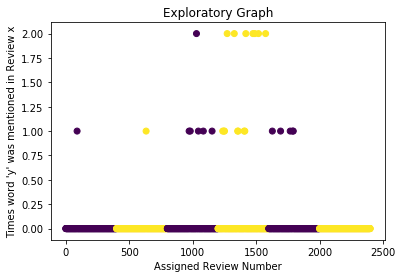

In [3]:
# Doing exploratory Graph for word #2. This can be done for any word
plt.scatter(range(0,2400),X[:,2],c=Y[:,0]) 
plt.title("Exploratory Graph")
plt.xlabel("Assigned Review Number")
plt.ylabel("Times word 'y' was mentioned in Review x")

In [4]:
#Separating the training data into pre-validation sets in order to compare several models and to choose the best model later

validation_size = 0.20
seed = 7
X_train, X_validation, Y_train, Y_validation = model_selection.train_test_split(X, Y.ravel(), test_size=validation_size, random_state=seed)

In [5]:
#setting up and choosing the models to compare
models = []
models.append(('KNN', KNeighborsClassifier(10)))
models.append(('NBC', MultinomialNB()))
models.append(('LogReg',LogisticRegression(solver='lbfgs',multi_class='ovr')))
models.append(('Tree', DecisionTreeClassifier()))
#models.append(('LSVC', LinearSVC()))
models.append(('LSVC', SVC(kernel='linear',probability=True)))

In [6]:
#evaluating the models on the previously separated training data
resultTrain = []
ModelTypesTrain = []
scoringTrain = 'accuracy'

print('')
print('Accuracy when compared to separated data within the traning data set:')

for ModelType, model in models:
	kfold = model_selection.KFold(n_splits = 5, random_state = 42)
	Xvalidation_results = model_selection.cross_val_score(model, X_train, Y_train, cv = kfold, scoring = scoringTrain)
	resultTrain.append(Xvalidation_results)
	ModelTypesTrain.append(ModelType)
	print (ModelType,Xvalidation_results.mean(), Xvalidation_results.std())



Accuracy when compared to separated data within the traning data set:
KNN 0.6468749999999999 0.029673790694258566
NBC 0.7651041666666666 0.014583333333333351
LogReg 0.7817708333333334 0.01682864002229531
Tree 0.6890625 0.02170069443333297
LSVC 0.7666666666666667 0.01036445246986062



Metrics when compared to validation data: 

KNN 
accuracy: 0.6433333333333333

classification report: 
               precision    recall  f1-score   support

           0       0.59      0.91      0.72       300
           1       0.80      0.38      0.52       300

   micro avg       0.64      0.64      0.64       600
   macro avg       0.70      0.64      0.62       600
weighted avg       0.70      0.64      0.62       600

Confusion Matrix: 
 [[272  28]
 [186 114]] 

ROC area under curve: 0.7384388888888889
Average Precision Score: 0.6150704225352113 


NBC 
accuracy: 0.77

classification report: 
               precision    recall  f1-score   support

           0       0.76      0.79      0.77       300
           1       0.78      0.75      0.77       300

   micro avg       0.77      0.77      0.77       600
   macro avg       0.77      0.77      0.77       600
weighted avg       0.77      0.77      0.77       600

Confusion Matrix: 
 [[237  63]
 [ 75 225]] 

ROC area under cu

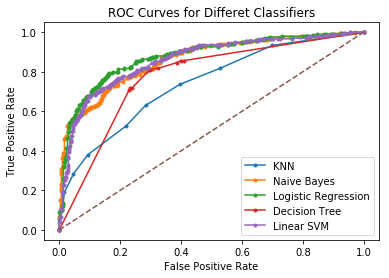

In [7]:
#Using models to make predictions and compare to the validation/test data set

resultsReal = []
ModelTypesReal = []
yscore =[]
print('')
print('Metrics when compared to validation data: \n')

for ModelType, model in models:
	model.fit(X,Y.ravel())
	result = model.predict(Xtest)
	probs = model.predict_proba(Xtest)
	probs = probs[:, 1]
	resultsReal.append(result)
	ModelTypesReal.append(ModelType)
	print (ModelType,"\naccuracy:", accuracy_score(Ytest.ravel(),result))
	print ("\nclassification report: \n",classification_report(Ytest.ravel(),result))
	print("Confusion Matrix:","\n",confusion_matrix(Ytest.ravel(),result),"\n")
	print("ROC area under curve:", roc_auc_score(Ytest.ravel(),probs))
	print("Average Precision Score:",average_precision_score(Ytest.ravel(),result),"\n\n")
	fpr, tpr, thresholds = roc_curve(Ytest.ravel(), probs)
	plt.plot(fpr, tpr, marker='.')
    
plt.title("ROC Curves for Differet Classifiers")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(["KNN","Naive Bayes","Logistic Regression","Decision Tree","Linear SVM"])
plt.plot([0, 1], [0, 1], linestyle='--')


In [2]:
##########Feature selection###### 

#choosing most representative words using recursive feature elimination (RFE)
#from https://machinelearningmastery.com/feature-selection-in-python-with-scikit-learn/

from sklearn import datasets
from sklearn.feature_selection import RFE

numFeatures = 20 #number of words that we want to use

rfe = RFE(MultinomialNB(),numFeatures)
#rfe = RFE(LogisticRegression(solver='lbfgs',multi_class='ovr'),numFeatures) #takes to long
#rfe = RFE(DecisionTreeClassifier(),numFeatures)
#rfe = RFE(LinearSVC(),numFeatures)
rfe = rfe.fit(X,Y.ravel())


bestVocab = []
num = 0 

#choosing the best words from the rfe analysis and putting them into a dictinoary
for bool in rfe.support_:
	if bool  == True:
		bestVocab.append(vocab.iloc[num,0]) 
	num =num+1

print(bestVocab)
    
n=0

#writing a text file with most representative words
with open('bestVocab.txt', 'w') as f:
    for item in bestVocab:
        f.write("%s\n" % bestVocab[n])
        n = n + 1

NameError: name 'MultinomialNB' is not defined

In [9]:
#Running fit based on 20 best words with Naive Bayes

model = MultinomialNB()
NBCFeatureAccuracy = []
NBCFeaturePrecision = []
NBCFeatureAUC=[]
FeatureNumber =[20,50,100,200,300,400,541]

bof20Best = pandas.read_csv("20Best_bag_of_words_0.csv",header = None)
bof20BestTest = pandas.read_csv("20BestTest_bag_of_words_0.csv",header = None)
X20Best = bof20Best.values
X20BestTest = bof20BestTest.values

model.fit(X20Best,Y.ravel())
Best20Result = model.predict(X20BestTest) 
print ("Best20", accuracy_score(Ytest.ravel(),Best20Result))
NBCFeatureAccuracy.append(accuracy_score(Ytest.ravel(),Best20Result))
NBCFeaturePrecision.append(average_precision_score(Ytest.ravel(),Best20Result))
probs = model.predict_proba(X20BestTest)
NBCFeatureAUC.append(roc_auc_score(Ytest.ravel(),probs[:,1]))

#Running fit based on 50 best words with Naive Bayes

bof50Best = pandas.read_csv("50Best_bag_of_words_0.csv",header = None)
bof50BestTest = pandas.read_csv("50BestTest_bag_of_words_0.csv",header = None)
X50Best = bof50Best.values
X50BestTest = bof50BestTest.values

model.fit(X50Best,Y.ravel())
Best50Result = model.predict(X50BestTest)
print ("Best50", accuracy_score(Ytest.ravel(),Best50Result))
NBCFeatureAccuracy.append(accuracy_score(Ytest.ravel(),Best50Result))
NBCFeaturePrecision.append(average_precision_score(Ytest.ravel(),Best50Result))
probs = model.predict_proba(X50BestTest)
NBCFeatureAUC.append(roc_auc_score(Ytest.ravel(),probs[:,1]))

#Running fit based on 100 best words with Naive Bayes

bof100Best = pandas.read_csv("100Best_bag_of_words_0.csv",header = None)
bof100BestTest = pandas.read_csv("100BestTest_bag_of_words_0.csv",header = None)
X100Best = bof100Best.values
X100BestTest = bof100BestTest.values

model.fit(X100Best,Y.ravel())
Best100Result = model.predict(X100BestTest)
print ("Best100", accuracy_score(Ytest.ravel(),Best100Result))
NBCFeatureAccuracy.append(accuracy_score(Ytest.ravel(),Best100Result))
NBCFeaturePrecision.append(average_precision_score(Ytest.ravel(),Best100Result))
probs = model.predict_proba(X100BestTest)
NBCFeatureAUC.append(roc_auc_score(Ytest.ravel(),probs[:,1]))

#Running fit based on 200 best words with Naive Bayes

bof200Best = pandas.read_csv("200Best_bag_of_words_0.csv",header = None)
bof200BestTest = pandas.read_csv("200BestTest_bag_of_words_0.csv",header = None)
X200Best = bof200Best.values
X200BestTest = bof200BestTest.values

model.fit(X200Best,Y.ravel())
Best200Result = model.predict(X200BestTest)
print ("Best200", accuracy_score(Ytest.ravel(),Best200Result))
NBCFeatureAccuracy.append(accuracy_score(Ytest.ravel(),Best200Result))
NBCFeaturePrecision.append(average_precision_score(Ytest.ravel(),Best200Result))
probs = model.predict_proba(X200BestTest)
NBCFeatureAUC.append(roc_auc_score(Ytest.ravel(),probs[:,1]))


#Running fit based on 300 best words with Naive Bayes

bof300Best = pandas.read_csv("300Best_bag_of_words_0.csv",header = None)
bof300BestTest = pandas.read_csv("300BestTest_bag_of_words_0.csv",header = None)
X300Best = bof300Best.values
X300BestTest = bof300BestTest.values

model.fit(X300Best,Y.ravel())
Best300Result = model.predict(X300BestTest)
print ("Best300", accuracy_score(Ytest.ravel(),Best300Result))
NBCFeatureAccuracy.append(accuracy_score(Ytest.ravel(),Best300Result))
NBCFeaturePrecision.append(average_precision_score(Ytest.ravel(),Best300Result))
probs = model.predict_proba(X300BestTest)
NBCFeatureAUC.append(roc_auc_score(Ytest.ravel(),probs[:,1]))

#Running fit based on 400 best words with Naive Bayes

bof400Best = pandas.read_csv("400Best_bag_of_words_0.csv",header = None)
bof400BestTest = pandas.read_csv("400BestTest_bag_of_words_0.csv",header = None)
X400Best = bof400Best.values
X400BestTest = bof400BestTest.values

model.fit(X400Best,Y.ravel())
Best400Result = model.predict(X400BestTest)
print ("Best400", accuracy_score(Ytest.ravel(),Best400Result))
NBCFeatureAccuracy.append(accuracy_score(Ytest.ravel(),Best400Result))
NBCFeatureAccuracy.append(0.77) #for full vocabulary
NBCFeaturePrecision.append(average_precision_score(Ytest.ravel(),Best400Result))
NBCFeaturePrecision.append(0.71) #for full vocabulary
probs = model.predict_proba(X400BestTest)
NBCFeatureAUC.append(roc_auc_score(Ytest.ravel(),probs[:,1]))
NBCFeatureAUC.append(0.86) #for full vocabulary

Best20 0.48833333333333334
Best50 0.4633333333333333
Best100 0.475
Best200 0.505
Best300 0.5483333333333333
Best400 0.61


In [10]:
#Running fit based on 20 best words with log regression
LogRegFeatureAccuracy = []
LogRegFeaturePrecision = []
LogRegFeatureAUC = []

model = LogisticRegression(solver='lbfgs',multi_class='ovr')

bof20Best = pandas.read_csv("20BestLogReg_bag_of_words_0.csv",header = None)
bof20BestTest = pandas.read_csv("20BestLogRegTest_bag_of_words_0.csv",header = None)
X20Best = bof20Best.values
X20BestTest = bof20BestTest.values

model.fit(X20Best,Y.ravel())
Best20Result = model.predict(X20BestTest) 
print ("Best20LogReg", accuracy_score(Ytest.ravel(),Best20Result))
LogRegFeatureAccuracy.append(accuracy_score(Ytest.ravel(),Best20Result))
LogRegFeaturePrecision.append(average_precision_score(Ytest.ravel(),Best20Result))
probs = model.predict_proba(X20BestTest)
LogRegFeatureAUC.append(roc_auc_score(Ytest.ravel(),probs[:,1]))

#Running fit based on 50 best words with log regression

bof50Best = pandas.read_csv("50BestLogReg_bag_of_words_0.csv",header = None)
bof50BestTest = pandas.read_csv("50BestLogRegTest_bag_of_words_0.csv",header = None)
X50Best = bof50Best.values
X50BestTest = bof50BestTest.values

model.fit(X50Best,Y.ravel())
Best50Result = model.predict(X50BestTest)
print ("Best50LogReg", accuracy_score(Ytest.ravel(),Best50Result))
LogRegFeatureAccuracy.append(accuracy_score(Ytest.ravel(),Best50Result))
LogRegFeaturePrecision.append(average_precision_score(Ytest.ravel(),Best50Result))
probs = model.predict_proba(X50BestTest)
LogRegFeatureAUC.append(roc_auc_score(Ytest.ravel(),probs[:,1]))

#Running fit based on 100 best words with log regression

bof100Best = pandas.read_csv("100BestLogReg_bag_of_words_0.csv",header = None)
bof100BestTest = pandas.read_csv("100BestLogRegTest_bag_of_words_0.csv",header = None)
X100Best = bof100Best.values
X100BestTest = bof100BestTest.values

model.fit(X100Best,Y.ravel())
Best100Result = model.predict(X100BestTest)
print ("Best100LogReg", accuracy_score(Ytest.ravel(),Best100Result))
LogRegFeatureAccuracy.append(accuracy_score(Ytest.ravel(),Best100Result))
LogRegFeaturePrecision.append(average_precision_score(Ytest.ravel(),Best100Result))
probs = model.predict_proba(X100BestTest)
LogRegFeatureAUC.append(roc_auc_score(Ytest.ravel(),probs[:,1]))

#Running fit based on 200 best words with log regression

bof200Best = pandas.read_csv("200BestLogReg_bag_of_words_0.csv",header = None)
bof200BestTest = pandas.read_csv("200BestLogRegTest_bag_of_words_0.csv",header = None)
X200Best = bof200Best.values
X200BestTest = bof200BestTest.values

model.fit(X200Best,Y.ravel())
Best200Result = model.predict(X200BestTest)
print ("Best200LogReg", accuracy_score(Ytest.ravel(),Best200Result))
LogRegFeatureAccuracy.append(accuracy_score(Ytest.ravel(),Best200Result))
LogRegFeaturePrecision.append(average_precision_score(Ytest.ravel(),Best200Result))
probs = model.predict_proba(X200BestTest)
LogRegFeatureAUC.append(roc_auc_score(Ytest.ravel(),probs[:,1]))


#Running fit based on 300 best words with log regression

bof300Best = pandas.read_csv("300BestLogReg_bag_of_words_0.csv",header = None)
bof300BestTest = pandas.read_csv("300BestLogRegTest_bag_of_words_0.csv",header = None)
X300Best = bof300Best.values
X300BestTest = bof300BestTest.values

model.fit(X300Best,Y.ravel())
Best300Result = model.predict(X300BestTest)
print ("Best300LogReg", accuracy_score(Ytest.ravel(),Best300Result))
LogRegFeatureAccuracy.append(accuracy_score(Ytest.ravel(),Best300Result))
LogRegFeaturePrecision.append(average_precision_score(Ytest.ravel(),Best300Result))
probs = model.predict_proba(X300BestTest)
LogRegFeatureAUC.append(roc_auc_score(Ytest.ravel(),probs[:,1]))


#Running fit based on 400 best words

bof400Best = pandas.read_csv("400BestLogReg_bag_of_words_0.csv",header = None)
bof400BestTest = pandas.read_csv("400BestLogRegTest_bag_of_words_0.csv",header = None)
X400Best = bof400Best.values
X400BestTest = bof400BestTest.values

model.fit(X400Best,Y.ravel())
Best400Result = model.predict(X400BestTest)
print ("Best400LogReg", accuracy_score(Ytest.ravel(),Best400Result))
LogRegFeatureAccuracy.append(accuracy_score(Ytest.ravel(),Best400Result))
LogRegFeatureAccuracy.append(0.802) #for full vocabulary
LogRegFeaturePrecision.append(average_precision_score(Ytest.ravel(),Best400Result))
LogRegFeaturePrecision.append(0.75) #for full vocabulary
probs = model.predict_proba(X400BestTest)
LogRegFeatureAUC.append(roc_auc_score(Ytest.ravel(),probs[:,1]))
LogRegFeatureAUC.append(0.88) #for full vocabulary


Best20LogReg 0.6616666666666666
Best50LogReg 0.75
Best100LogReg 0.78
Best200LogReg 0.8166666666666667
Best300LogReg 0.8183333333333334
Best400LogReg 0.8083333333333333


In [11]:
#Running fit based on 20 best words with decision tree
model =DecisionTreeClassifier()
TreeFeatureAccuracy = []
TreeFeaturePrecision = []
TreeFeatureAUC = []


bof20Best = pandas.read_csv("20BestTree_bag_of_words_0.csv",header = None)
bof20BestTest = pandas.read_csv("20BestTreeTest_bag_of_words_0.csv",header = None)
X20Best = bof20Best.values
X20BestTest = bof20BestTest.values

model.fit(X20Best,Y.ravel())
Best20Result = model.predict(X20BestTest) 
print ("Best20Tree", accuracy_score(Ytest.ravel(),Best20Result))
TreeFeatureAccuracy.append(accuracy_score(Ytest.ravel(),Best20Result))
TreeFeaturePrecision.append(average_precision_score(Ytest.ravel(),Best20Result))
probs = model.predict_proba(X20BestTest)
TreeFeatureAUC.append(roc_auc_score(Ytest.ravel(),probs[:,1]))


#Running fit based on 50 best words with log regression

bof50Best = pandas.read_csv("50BestTree_bag_of_words_0.csv",header = None)
bof50BestTest = pandas.read_csv("50BestTreeTest_bag_of_words_0.csv",header = None)
X50Best = bof50Best.values
X50BestTest = bof50BestTest.values

model.fit(X50Best,Y.ravel())
Best50Result = model.predict(X50BestTest)
print ("Best50Tree", accuracy_score(Ytest.ravel(),Best50Result))
TreeFeatureAccuracy.append(accuracy_score(Ytest.ravel(),Best50Result))
TreeFeaturePrecision.append(average_precision_score(Ytest.ravel(),Best50Result))
probs = model.predict_proba(X50BestTest)
TreeFeatureAUC.append(roc_auc_score(Ytest.ravel(),probs[:,1]))


#Running fit based on 100 best words with log regression

bof100Best = pandas.read_csv("100BestTree_bag_of_words_0.csv",header = None)
bof100BestTest = pandas.read_csv("100BestTreeTest_bag_of_words_0.csv",header = None)
X100Best = bof100Best.values
X100BestTest = bof100BestTest.values

model.fit(X100Best,Y.ravel())
Best100Result = model.predict(X100BestTest)
print ("Best100Test", accuracy_score(Ytest.ravel(),Best100Result))
TreeFeatureAccuracy.append(accuracy_score(Ytest.ravel(),Best100Result))
TreeFeaturePrecision.append(average_precision_score(Ytest.ravel(),Best100Result))
probs = model.predict_proba(X100BestTest)
TreeFeatureAUC.append(roc_auc_score(Ytest.ravel(),probs[:,1]))

#Running fit based on 200 best words with log regression

bof200Best = pandas.read_csv("200BestTree_bag_of_words_0.csv",header = None)
bof200BestTest = pandas.read_csv("200BestTreeTest_bag_of_words_0.csv",header = None)
X200Best = bof200Best.values
X200BestTest = bof200BestTest.values

model.fit(X200Best,Y.ravel())
Best200Result = model.predict(X200BestTest)
print ("Best200Tree", accuracy_score(Ytest.ravel(),Best200Result))
TreeFeatureAccuracy.append(accuracy_score(Ytest.ravel(),Best200Result))
TreeFeaturePrecision.append(average_precision_score(Ytest.ravel(),Best200Result))
probs = model.predict_proba(X200BestTest)
TreeFeatureAUC.append(roc_auc_score(Ytest.ravel(),probs[:,1]))


#Running fit based on 300 best words with log regression

bof300Best = pandas.read_csv("300BestTree_bag_of_words_0.csv",header = None)
bof300BestTest = pandas.read_csv("300BestTreeTest_bag_of_words_0.csv",header = None)
X300Best = bof300Best.values
X300BestTest = bof300BestTest.values

model.fit(X300Best,Y.ravel())
Best300Result = model.predict(X300BestTest)
print ("Best300Tree", accuracy_score(Ytest.ravel(),Best300Result))
TreeFeatureAccuracy.append(accuracy_score(Ytest.ravel(),Best300Result))
TreeFeaturePrecision.append(average_precision_score(Ytest.ravel(),Best300Result))
probs = model.predict_proba(X300BestTest)
TreeFeatureAUC.append(roc_auc_score(Ytest.ravel(),probs[:,1]))

#Running fit based on 400 best words

bof400Best = pandas.read_csv("400BestTree_bag_of_words_0.csv",header = None)
bof400BestTest = pandas.read_csv("400BestTreeTest_bag_of_words_0.csv",header = None)
X400Best = bof400Best.values
X400BestTest = bof400BestTest.values

model.fit(X400Best,Y.ravel())
Best400Result = model.predict(X400BestTest)
print ("Best400Tree", accuracy_score(Ytest.ravel(),Best400Result))
TreeFeatureAccuracy.append(accuracy_score(Ytest.ravel(),Best400Result))
TreeFeatureAccuracy.append(0.74) #for full vocabulary
TreeFeaturePrecision.append(average_precision_score(Ytest.ravel(),Best400Result))
TreeFeaturePrecision.append(0.67)
probs = model.predict_proba(X400BestTest)
TreeFeatureAUC.append(roc_auc_score(Ytest.ravel(),probs[:,1]))
TreeFeatureAUC.append(0.76)

Best20Tree 0.7066666666666667
Best50Tree 0.7566666666666667
Best100Test 0.7733333333333333
Best200Tree 0.7666666666666667
Best300Tree 0.7483333333333333
Best400Tree 0.7216666666666667


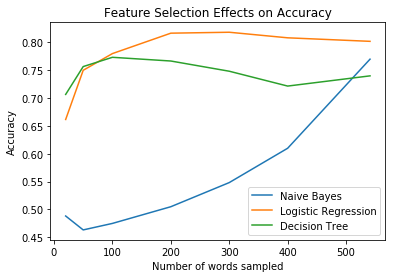

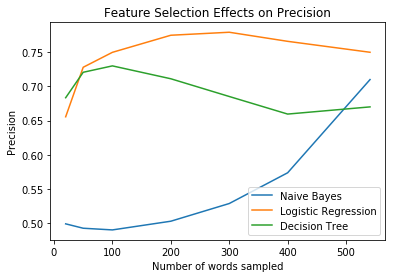

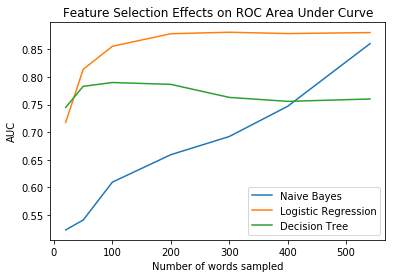

In [12]:
#plotting feature selection effects on accuracy

plt.plot(FeatureNumber,NBCFeatureAccuracy,FeatureNumber,LogRegFeatureAccuracy,FeatureNumber,TreeFeatureAccuracy,)
plt.title("Feature Selection Effects on Accuracy")
plt.xlabel("Number of words sampled")
plt.ylabel("Accuracy")
plt.legend(["Naive Bayes","Logistic Regression","Decision Tree"])

#plotting feature selection effects on precision
plt.figure()
plt.plot(FeatureNumber,NBCFeaturePrecision,FeatureNumber,LogRegFeaturePrecision,FeatureNumber,TreeFeaturePrecision,)
plt.title("Feature Selection Effects on Precision")
plt.xlabel("Number of words sampled")
plt.ylabel("Precision")
plt.legend(["Naive Bayes","Logistic Regression","Decision Tree"])

#plotting feature selection effects on AUC
plt.figure()
plt.plot(FeatureNumber,NBCFeatureAUC,FeatureNumber,LogRegFeatureAUC,FeatureNumber,TreeFeatureAUC)
plt.title("Feature Selection Effects on ROC Area Under Curve")
plt.xlabel("Number of words sampled")
plt.ylabel("AUC")
plt.legend(["Naive Bayes","Logistic Regression","Decision Tree"])

In [13]:
######adding length as a feature to the analysis#######
#from https://stackoverflow.com/questions/13970203/how-to-count-average-sentence-length-in-words-from-a-text-file-contains-100-se

#splitting each review into its words
def readLines(file):
    with open(file, 'r') as f:
        for line in f:
            yield line.strip()

#counting words in each line
def wordsInScentence(sentences):
    counts = []
    for sentence in sentences:
        #cunts.append(sentence.split()) #minus two because we have label and number
        counts.append(len(sentence.split())-2)#two because we have label and number
    return counts

#reading number of words in each data set (tranining and testing)
X2Train = wordsInScentence(readLines("train.txt"))
X2Train = np.reshape(X2Train,(-1, 1))

X2Test = wordsInScentence(readLines("test.txt"))
X2Test = np.reshape(X2Test,(-1, 1))


#setting up and choosing the models to compare
models2 = []
models2.append(('KNN', KNeighborsClassifier(10)))
models2.append(('NBC', MultinomialNB()))
models2.append(('LogReg',LogisticRegression(solver='lbfgs',multi_class='ovr')))
models2.append(('Tree', DecisionTreeClassifier()))

resultsReal2 = []
ModelTypesReal2=[]

print('')
print('Accuracy when using scentence length as the only feature')

for ModelType, model in models2:
	model.fit(X2Train,Y.ravel())
	result = model.predict(X2Test) 
	resultsReal2.append(result)
	ModelTypesReal2.append(ModelType)
	print (ModelType, accuracy_score(Ytest.ravel(),result))
	#print (classification_report(Ytest.ravel(),result))
	#print(confusion_matrix(Ytest.ravel(),result))	

#fitting model with length as only feature
#model = DecisionTreeClassifier()
#model = LogisticRegression(solver='lbfgs',multi_class='ovr')
model = MultinomialNB()
model.fit(X2Train,Y.ravel())
X2Result = model.predict(X2Test)
print ("with Length", accuracy_score(Ytest.ravel(),X2Result))

#fitting model using word AND length data
X2LengthTrain = np.concatenate((X,X2Train),axis = 1)
X2LengthTest = np.concatenate((Xtest,X2Test),axis = 1)

print('')
print('Accuracy when using scentence length and Bag of Words')

for ModelType, model in models2:
	model.fit(X2LengthTrain,Y.ravel())
	result = model.predict(X2LengthTest) 
	resultsReal2.append(result)
	ModelTypesReal2.append(ModelType)
	print (ModelType, accuracy_score(Ytest.ravel(),result))
	#print (classification_report(Ytest.ravel(),result))
	#print(confusion_matrix(Ytest.ravel(),result))	



Accuracy when using scentence length as the only feature
KNN 0.5183333333333333
NBC 0.5
LogReg 0.49
Tree 0.535
with Length 0.5

Accuracy when using scentence length and Bag of Words
KNN 0.5516666666666666
NBC 0.7733333333333333
LogReg 0.7966666666666666
Tree 0.7216666666666667
